# Vizuara Video

Consider a hypothetical experiment of throwing a ball up (or at an angle), and noting down the height of the ball at different points of time. When we plot height v/s time graph, we see near about a downward facing parabola. <p>
It is easy to train the neural network merely on this datasey so that we can predict the height of the ball even at time points where we did not note down the height. <p>
We can construct a nerual network with few or multiple  hidden layers. The input is time (t) & the output predicted by the neural network is height of the ball (h). <p>
The neural network will be initialized with random weights. This means the predictions of h(t) made by the neural network will be very bad initially. We can penalise the neural network for making these bad predictions using loss functions. <p>

## Loss functions
Mean squared error (MSE) is the best simplistic working loss function. It is minimum when the predictions are very close to experimental data. <p>
But the problem with this approach is that if the experimental data is not good, meaning it consists of outliers or noise in a dataset. <p>
Knowing that real life data may have noise and outliers, it will not be wise if we train a neural network to exactly mimic this dataset. It results in something called as overfitting. <p>

## Bring physics into the picture
If we are throwing a ball and observing its physics, then you already have some knowledge about the trajectory of the ball, based on Newton’s laws of motion. <p>
The physics may not be in perfect agreement with the experimental data, but it makes sense to think that the experiments will not deviate too much from physics. <p>
So if one of our experimental data points deviate too much from what physics says, there is probably something wrong with that data point. Here, we can teach physics to the neural network: PINN. <p>
The goal of PINNs is to solve (or learn solutions to) differential equations by embedding the known physics (or governing differential equations) directly into the neural network’s training objective (loss function). <p>
The basic idea in PINN is to have a neural network is trained to minimize a loss function that includes:
1. A data mismatch term (if observational data are available).
2. A physics loss term enforcing the differential equation itself (and initial/boundary conditions).

## Implementing PINN on our example
dh/dt=u0=gt <p>
u0: Initial velocity <br>
g: Acceleration due to gravity <br>
However this ODE alone cannot fully describe h(t) uniquely. We also need an initial condition.

### Loss due to dh/dt (ODE Loss)
dh^/dt=d/dt(NN(@)): Predicted <br>
dh/dt=u0-gt: Physics based <br>

ODE Loss= MSE(dh/dt, dh^/dt)

### Initial condition loss
h(0): Initial condition <br>
h^(0): Predicted initial condition <br>

IC loss = MSE(h(0), h^(0)) <p>

## The modified loss term
So, eventually there are 3 things to consider in a loss function:
1. We cannot throw away the experimental data.
2. We cannot neglect the physics described by the ODEs or PDEs.
3. We cannot neglect the initial and/or boundary conditions. <p> <p>
Loss=lambda1*Loss_data + lambda2*Loss_ODE + lambda3*Loss_IC <p>
If there are boundary conditions in addition to initial conditions, you can add an additional term based on the difference between predicted boundary conditions and actual boundary conditions. <p>
In short, in Physics Informed Neural Networks (PINN), you are “informing” the neural network that some physics is there behind the data in the form of modified loss function.

## Python implementation

Import required libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

Generate Synthetic Data

In [2]:
# Physics parameters
g = 9.8        # acceleration due to gravity
h0 = 1.0       # initial height
v0 = 10.0      # initial velocity

# True (analytical) solution h(t) = h0 + v0*t - 0.5*g*t^2
def true_solution(t):
    return h0 + v0*t - 0.5*g*(t**2)

# Generate some time points
t_min, t_max = 0.0, 2.0
N_data = 10
t_data = np.linspace(t_min, t_max, N_data)

# Generate synthetic "experimental" heights with noise
np.random.seed(0)
noise_level = 0.7
h_data_exact = true_solution(t_data)
h_data_noisy = h_data_exact + noise_level*np.random.randn(N_data)

# Convert to PyTorch tensors
t_data_tensor = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)
h_data_tensor = torch.tensor(h_data_noisy, dtype=torch.float32).view(-1, 1)

Define a small feed-forward neural network for h(t)

In [3]:
class PINN(nn.Module):
    def __init__(self, n_hidden=20):
        super(PINN, self).__init__()
        # A simple MLP with 2 hidden layers
        self.net = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, t):
        """
        Forward pass: input shape (batch_size, 1) -> output shape (batch_size, 1)
        """
        return self.net(t)

# Instantiate the model
model = PINN(n_hidden=20)

Helper for Automatic Differentiation

In [4]:
def derivative(y, x):
    """
    Computes dy/dx using PyTorch's autograd.
    y and x must be tensors with requires_grad=True for x.
    """
    return torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

Define the Loss Components (PINN)

In [5]:
def physics_loss(model, t):
    """
    Compare d(h_pred)/dt with the known expression (v0 - g t).
    """
    # t must have requires_grad = True for autograd to work
    t.requires_grad_(True)

    h_pred = model(t)
    dh_dt_pred = derivative(h_pred, t)

    # For each t, physics says dh/dt = v0 - g * t
    dh_dt_true = v0 - g * t

    loss_ode = torch.mean((dh_dt_pred - dh_dt_true)**2)
    return loss_ode

def initial_condition_loss(model):
    """
    Enforce h(0) = h0.
    """
    # Evaluate at t=0
    t0 = torch.zeros(1, 1, dtype=torch.float32, requires_grad=False)
    h0_pred = model(t0)
    return (h0_pred - h0).pow(2).mean()

def data_loss(model, t_data, h_data):
    """
    MSE between predicted h(t_i) and noisy measurements h_data.
    """
    h_pred = model(t_data)
    return torch.mean((h_pred - h_data)**2)

Training Setup

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Hyperparameters for weighting the loss terms
lambda_data = 2.0
lambda_ode  = 2.0
lambda_ic   = 2.0

# For logging
num_epochs = 4000
print_every = 200

Training Loop

In [7]:
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Compute losses
    l_data = data_loss(model, t_data_tensor, h_data_tensor)
    l_ode  = physics_loss(model, t_data_tensor)
    l_ic   = initial_condition_loss(model)

    # Combined loss
    loss = lambda_data * l_data + lambda_ode * l_ode + lambda_ic * l_ic

    # Backprop
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % print_every == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Total Loss = {loss.item():.6f}, "
              f"Data Loss = {l_data.item():.6f}, "
              f"ODE Loss = {l_ode.item():.6f}, "
              f"IC Loss = {l_ic.item():.6f}")

Epoch 200/4000, Total Loss = 1.073887, Data Loss = 0.481902, ODE Loss = 0.022120, IC Loss = 0.032921
Epoch 400/4000, Total Loss = 1.045507, Data Loss = 0.476268, ODE Loss = 0.022485, IC Loss = 0.024001
Epoch 600/4000, Total Loss = 1.029651, Data Loss = 0.477497, ODE Loss = 0.021668, IC Loss = 0.015661
Epoch 800/4000, Total Loss = 1.025487, Data Loss = 0.477529, ODE Loss = 0.021272, IC Loss = 0.013942
Epoch 1000/4000, Total Loss = 1.022023, Data Loss = 0.475564, ODE Loss = 0.021718, IC Loss = 0.013729
Epoch 1200/4000, Total Loss = 1.019229, Data Loss = 0.473978, ODE Loss = 0.022205, IC Loss = 0.013431
Epoch 1400/4000, Total Loss = 1.016379, Data Loss = 0.472475, ODE Loss = 0.022478, IC Loss = 0.013237
Epoch 1600/4000, Total Loss = 1.012721, Data Loss = 0.470380, ODE Loss = 0.022904, IC Loss = 0.013077
Epoch 1800/4000, Total Loss = 1.007484, Data Loss = 0.467180, ODE Loss = 0.023655, IC Loss = 0.012907
Epoch 2000/4000, Total Loss = 1.019765, Data Loss = 0.476886, ODE Loss = 0.023189, IC 

Evaluate the Trained Model

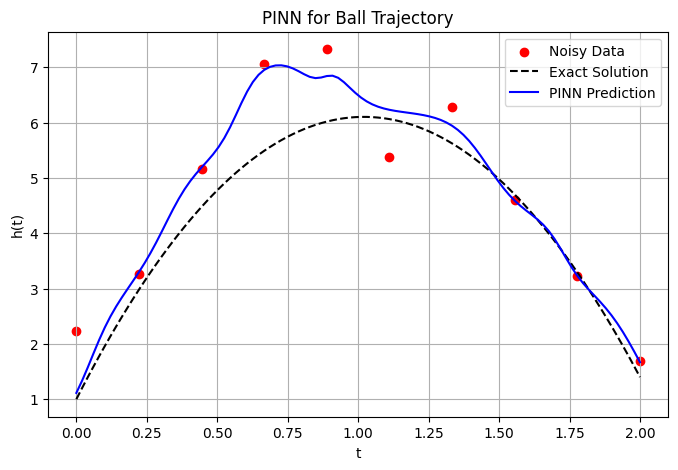

In [8]:
model.eval()
t_plot = np.linspace(t_min, t_max, 100).reshape(-1, 1).astype(np.float32)
t_plot_tensor = torch.tensor(t_plot, requires_grad=True)
h_pred_plot = model(t_plot_tensor).detach().numpy()

# True solution (for comparison)
h_true_plot = true_solution(t_plot)

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(t_data, h_data_noisy, color='red', label='Noisy Data')
plt.plot(t_plot, h_true_plot, 'k--', label='Exact Solution')
plt.plot(t_plot, h_pred_plot, 'b', label='PINN Prediction')
plt.xlabel('t')
plt.ylabel('h(t)')
plt.legend()
plt.title('PINN for Ball Trajectory')
plt.grid(True)
plt.show()